Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


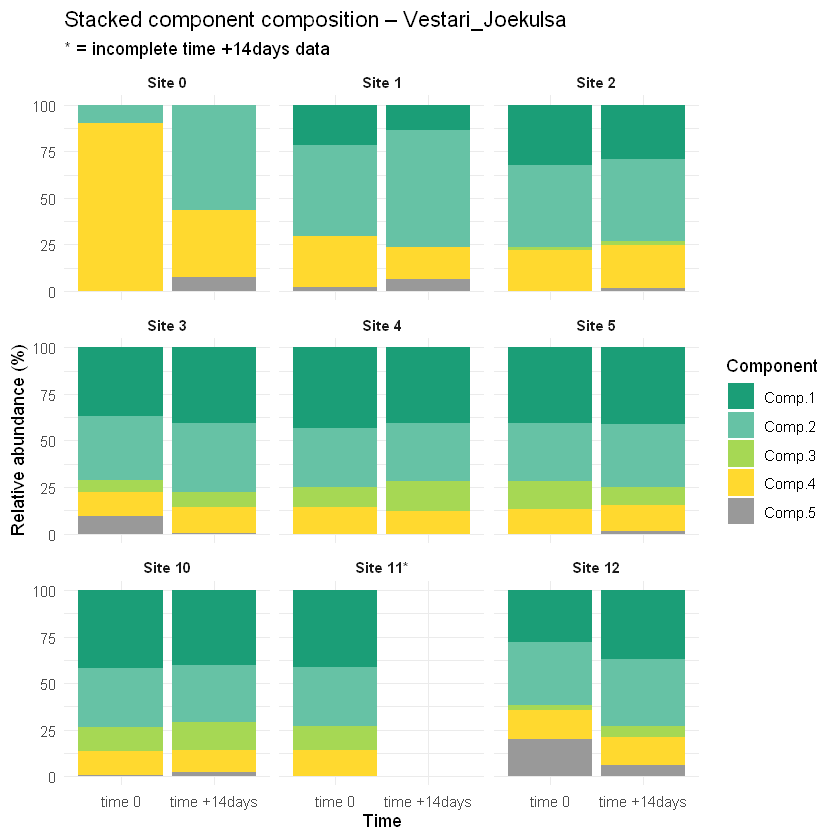

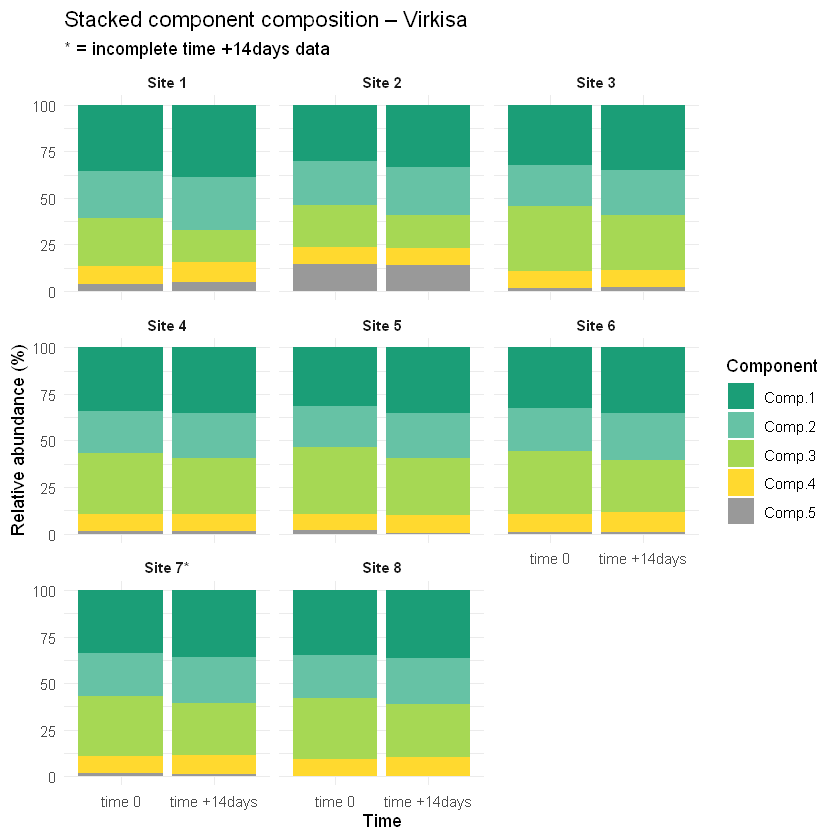

In [4]:
## Hüsch und final

# Load packages
library(readxl)
library(dplyr)
library(tidyr)
library(ggplot2)

# 1. Load Excel file
file_path <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
df <- read_excel(file_path)

# 2. Identify problematic sites where sum of time+14days components ≠ 100%
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3. Transform data to long format
df_long <- df %>%
  # time 0
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = starts_with("pctComp.") & !ends_with("_B"),
               names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    # time +14days
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"),
                   names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4. Calculate mean and normalize to 100% per site and timepoint
df_normalized <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5. Mark problematic sites with *
df_normalized <- df_normalized %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in% paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel = ifelse(is_problem,
                       paste0("Site ", site_nr, "*"),
                       paste0("Site ", site_nr))
  )

# 6. Sort sites numerically
site_order <- df_normalized %>%
  distinct(site_nr, SiteLabel) %>%
  arrange(site_nr) %>%
  pull(SiteLabel)

df_normalized$SiteLabel <- factor(df_normalized$SiteLabel, levels = site_order)

# 7. Component labels and new gradient-inspired color palette
component_labels <- c(
  "pctComp.1" = "Comp.1",
  "pctComp.2" = "Comp.2",
  "pctComp.3" = "Comp.3",
  "pctComp.4" = "Comp.4",
  "pctComp.5" = "Comp.5"
)

component_colors <- c(
  "Comp.1" = "#1b9e77",  # kräftiges Türkis-Grün
  "Comp.2" = "#66c2a5",  # helleres Türkis
  "Comp.3" = "#a6d854",  # gelb-grün
  "Comp.4" = "#ffd92f",  # gelb
  "Comp.5" = "#999999"   # grau
)

# Apply labels
df_normalized$ComponentLabel <- component_labels[as.character(df_normalized$Component)]
df_normalized$ComponentLabel <- factor(df_normalized$ComponentLabel, levels = names(component_colors))

# 8. Plot by river
for (river in unique(df_normalized$river_name)) {
  df_river <- df_normalized %>% filter(river_name == river)

  p <- ggplot(df_river, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)",
      fill = "Component"
    ) +
    theme_minimal() +
    theme(strip.text = element_text(face = "bold"))

  print(p)
}


In [5]:
df_river %>% filter(is.na(Percent))


river_name,site_nr,Time,Component,Percent,is_problem,SiteLabel,ComponentLabel
<chr>,<dbl>,<fct>,<fct>,<dbl>,<lgl>,<fct>,<fct>


In [6]:
df_river %>% filter(Percent < 0 | Percent > 100 | is.infinite(Percent))


river_name,site_nr,Time,Component,Percent,is_problem,SiteLabel,ComponentLabel
<chr>,<dbl>,<fct>,<fct>,<dbl>,<lgl>,<fct>,<fct>


💬 Zusammenfassung

    ✅ Kein NA → geprüft ✔️

    ✅ Kein <0 oder >100 → geprüft ✔️

    ✅ Keine unendlichen Werte → geprüft ✔️

    ✅ Warnung kommt nur von leeren Slots bei Facets → harmlos

### als Tabellen

In [1]:
library(dplyr)
library(tidyr)

# Time-Faktor vorbereiten
df_long <- df_long %>%
  mutate(Time = factor(Time, levels = c("time 0", "time +14days")))

# Normalisiert
df_summary_norm <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup() %>%
  mutate(Percent = round(Percent, 2))

# Pro Fluss Tabellen
rivers <- unique(df_summary_norm$river_name)

tables_norm <- list()

for (river in rivers) {
  df_river <- df_summary_norm %>% filter(river_name == river)
  
  # Component-Namen schöner
  df_river <- df_river %>%
    mutate(Component = recode(Component,
                              "pctComp.1" = "Comp.1",
                              "pctComp.2" = "Comp.2",
                              "pctComp.3" = "Comp.3",
                              "pctComp.4" = "Comp.4",
                              "pctComp.5" = "Comp.5"))
  
  # Pivot
  df_pivot <- df_river %>%
    pivot_wider(names_from = c(site_nr, Time), values_from = Percent)

  tables_norm[[river]] <- df_pivot
}

tables_norm



Attache Paket: 'dplyr'


Die folgenden Objekte sind maskiert von 'package:stats':

    filter, lag


Die folgenden Objekte sind maskiert von 'package:base':

    intersect, setdiff, setequal, union




ERROR: Error: Objekt 'df_long' nicht gefunden


In [2]:
# Unnormalisiert
df_summary_raw <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  ungroup() %>%
  mutate(Percent = round(Percent, 2))

tables_raw <- list()

for (river in rivers) {
  df_river <- df_summary_raw %>% filter(river_name == river)
  
  df_river <- df_river %>%
    mutate(Component = recode(Component,
                              "pctComp.1" = "Comp.1",
                              "pctComp.2" = "Comp.2",
                              "pctComp.3" = "Comp.3",
                              "pctComp.4" = "Comp.4",
                              "pctComp.5" = "Comp.5"))
  
  df_pivot <- df_river %>%
    pivot_wider(names_from = c(site_nr, Time), values_from = Percent)

  tables_raw[[river]] <- df_pivot
}

tables_raw


ERROR: Error: Objekt 'df_long' nicht gefunden


# Mit prozentangaben

Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."


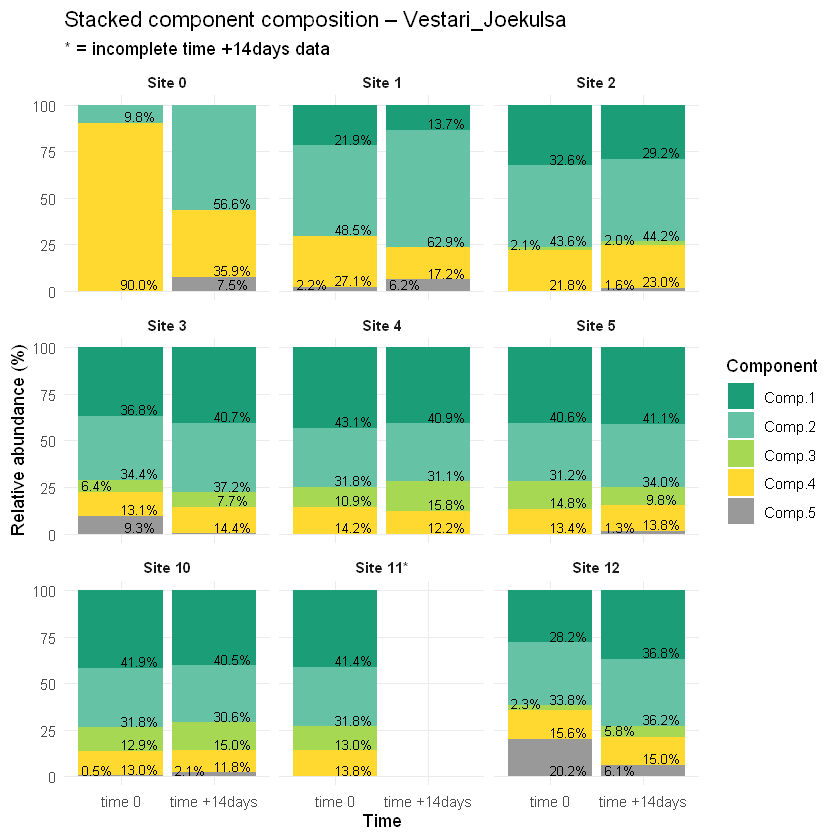

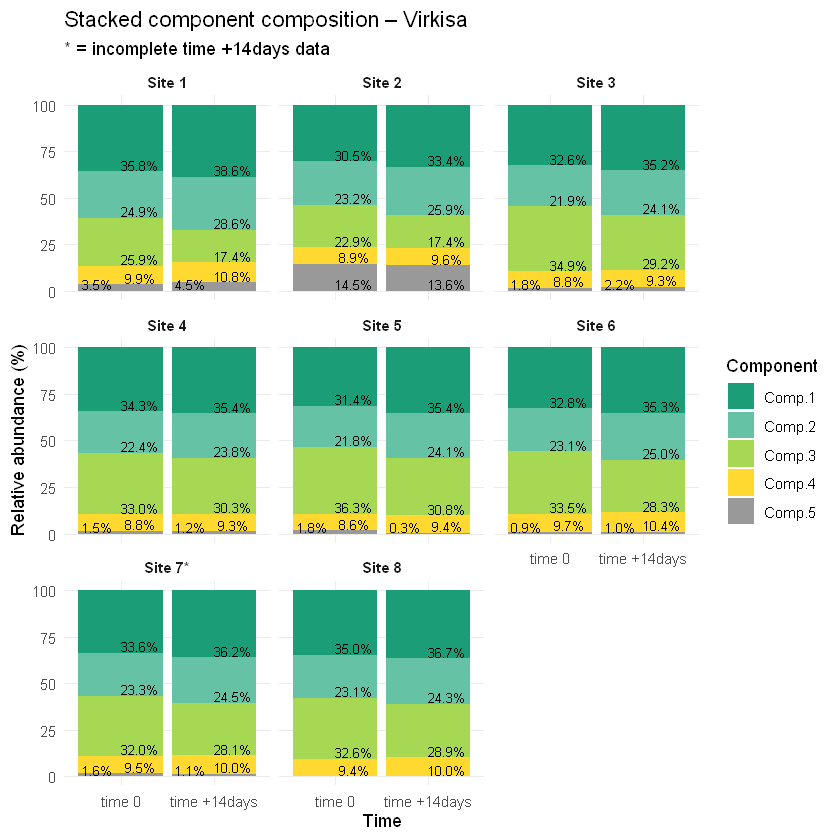

In [35]:
# ---- Setup ----
suppressPackageStartupMessages({
  library(readxl); library(dplyr); library(tidyr); library(ggplot2)
})

# 1) Daten laden (Windows-Pfad, Fallback: /mnt/data)
win_file <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/MASTER_DATA_Components.xlsx"
in_file  <- if (file.exists(win_file)) win_file else "/mnt/data/MASTER_DATA_Components.xlsx"
df <- read_excel(in_file)

# 2) Problem-Sites markieren (Summe der _B-Komponenten != 100 %)
problem_sites <- df %>%
  mutate(sum_time14 = rowSums(select(., pctComp.1_B:pctComp.5_B), na.rm = TRUE)) %>%
  filter(abs(sum_time14 - 1) > 0.01) %>%
  distinct(river_name, site_nr)

# 3) Long-Format (time 0 und time +14days)
df_long <- df %>%
  select(river_name, group_nr, site_nr,
         pctComp.1, pctComp.2, pctComp.3, pctComp.4, pctComp.5,
         pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
  pivot_longer(cols = c(pctComp.1:pctComp.5), names_to = "Component", values_to = "Percent") %>%
  mutate(Time = "time 0") %>%
  bind_rows(
    df %>%
      select(river_name, group_nr, site_nr,
             pctComp.1_B, pctComp.2_B, pctComp.3_B, pctComp.4_B, pctComp.5_B) %>%
      rename_with(~ gsub("_B$", "", .x), starts_with("pctComp")) %>%
      pivot_longer(cols = starts_with("pctComp"), names_to = "Component", values_to = "Percent") %>%
      mutate(Time = "time +14days")
  ) %>%
  mutate(
    Time = factor(Time, levels = c("time 0", "time +14days")),
    Component = factor(Component, levels = paste0("pctComp.", 1:5))
  )

# 4) Mittelwert je Site/Time & auf 100 % normieren
df_norm <- df_long %>%
  group_by(river_name, site_nr, Time, Component) %>%
  summarise(Percent = mean(Percent, na.rm = TRUE), .groups = "drop") %>%
  group_by(river_name, site_nr, Time) %>%
  mutate(Percent = Percent / sum(Percent, na.rm = TRUE) * 100) %>%
  ungroup()

# 5) Problem-Sites kennzeichnen und Site-Labels ordnen
df_norm <- df_norm %>%
  mutate(
    is_problem = paste(river_name, site_nr) %in% paste(problem_sites$river_name, problem_sites$site_nr),
    SiteLabel  = ifelse(is_problem, paste0("Site ", site_nr, "*"), paste0("Site ", site_nr))
  )
site_order <- df_norm %>% distinct(site_nr, SiteLabel) %>% arrange(site_nr) %>% pull(SiteLabel)
df_norm$SiteLabel <- factor(df_norm$SiteLabel, levels = site_order)

# 6) Farben & Anzeigenamen
component_labels <- c(
  "pctComp.1"="Comp.1","pctComp.2"="Comp.2","pctComp.3"="Comp.3",
  "pctComp.4"="Comp.4","pctComp.5"="Comp.5"
)
component_colors <- c(
  "Comp.1"="#1b9e77","Comp.2"="#66c2a5","Comp.3"="#a6d854","Comp.4"="#ffd92f","Comp.5"="#999999"
)
df_norm <- df_norm %>%
  mutate(ComponentLabel = factor(component_labels[as.character(Component)],
                                 levels = names(component_colors)))

# 7) Label-Tabelle: Text, hjust nach 3%-Regel, Position knapp über der unteren Segmentlinie
labels_df <- df_norm %>%
  group_by(river_name, site_nr, Time) %>%
  arrange(Component, .by_group = TRUE) %>%  # Reihenfolge Comp.1..5 bleibt
  ungroup() %>%
  mutate(
    label_txt = ifelse(round(Percent, 1) <= 0.2, NA_character_,
                       paste0(format(round(Percent, 1), nsmall = 1), "%")),
    hjust_val = ifelse(Percent < 6.5, 1.25, 0)   # <3% rechtsbündig, sonst links
  )

# 8) Plot je Fluss
for (river in unique(df_norm$river_name)) {
  d <- df_norm  %>% filter(river_name == river)
  l <- labels_df %>% filter(river_name == river)

  p <- ggplot(d, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    # Labels: Position exakt auf der unteren Segmentlinie (vjust leicht negativ = "über der Linie")
    geom_text(
      data = l, aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0), vjust = -0.15, size = 2.7, na.rm = TRUE
    ) +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)", fill = "Component"
    ) +
    coord_cartesian(ylim = c(0, 100)) +
    theme_minimal(base_size = 11) +
    theme(
      strip.text = element_text(face = "bold"),
      panel.grid.minor = element_blank()
    )

  print(p)
}


In [36]:
# ---- Export Setup ----
out_dir <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/Ergebnisse_Saeulen"
if (!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

# A4 Maße in Zoll (210 × 297 mm)
a4_width  <- 210 / 25.4   # ~8.27 inch
a4_height <- 297 / 25.4   # ~11.7 inch

# ---- Plot + Save je Fluss ----
for (river in unique(df_norm$river_name)) {
  d <- df_norm  %>% filter(river_name == river)
  l <- labels_df %>% filter(river_name == river)

  p <- ggplot(d, aes(x = Time, y = Percent, fill = ComponentLabel)) +
    geom_bar(stat = "identity") +
    geom_text(
      data = l, aes(label = label_txt, hjust = hjust_val),
      position = position_stack(vjust = 0), vjust = -0.15, size = 3, na.rm = TRUE
    ) +
    facet_wrap(~ SiteLabel, scales = "fixed") +
    scale_fill_manual(values = component_colors, drop = FALSE) +
    labs(
      title = paste("Stacked component composition –", river),
      subtitle = "* = incomplete time +14days data",
      x = "Time", y = "Relative abundance (%)", fill = "Component"
    ) +
    coord_cartesian(ylim = c(0, 100)) +
    theme_minimal(base_size = 11) +
    theme(
      strip.text = element_text(face = "bold"),
      panel.grid.minor = element_blank()
    )

  # ---- Speichern als PNG ----
  ggsave(
    filename = file.path(out_dir, paste0("Saeulen_", river, ".png")),
    plot = p,
    width = a4_width, height = a4_height, units = "in", dpi = 300
  )
}


Warning message:
"Removed 5 rows containing missing values or values outside the scale range (`geom_bar()`)."
